In [1]:
#!pip install torch torchvision torchaudio
#!pip install captum

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from captum.attr import IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz

%matplotlib inline

In [9]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


![CIFAR-10](https://pytorch.org/tutorials/_images/cifar10.png)

In [10]:
# load CIFAR-10 dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

# Separating trainset/testset data/label
X_train_valid = np.array(trainset.data).astype(np.float32)
X_test = np.array(testset.data).astype(np.float32)
y_train_valid = np.array(trainset.targets)
y_test = np.array(testset.targets)

Files already downloaded and verified
Files already downloaded and verified


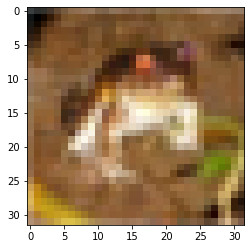

In [11]:
plt.imshow(X_train_valid[0,:].astype(int))

In [12]:
# image input should be [B, C, H, W]
X_train_valid = np.transpose(X_train_valid, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# select cats & dogs for train dataset
ind_cat_dog_train = [i for i in range(len(y_train_valid)) if (y_train_valid[i] == classDict['cat']) | (y_train_valid[i] == classDict['dog'])]
X_train_valid = X_train_valid[ind_cat_dog_train, :, :, :]
y_train_valid = y_train_valid[ind_cat_dog_train]

# relabel targets
y_train_valid[y_train_valid == classDict['cat']] = 0
y_train_valid[y_train_valid == classDict['dog']] = 1

# select cats & dogs for test dataset
ind_cat_dog_test = [i for i in range(len(y_test)) if (y_test[i] == classDict['cat']) | (y_test[i] == classDict['dog'])]
X_test = X_test[ind_cat_dog_test, :, :, :]
y_test = y_test[ind_cat_dog_test]

# relabel targets
y_test[y_test == classDict['cat']] = 0
y_test[y_test == classDict['dog']] = 1

# get the validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)

# tensorize data & instantiate data loaders
ts_X_train, ts_y_train, ts_X_valid, ts_y_valid, ts_X_test, ts_y_test = map(
    torch.tensor, (X_train, y_train, X_valid, y_valid, X_test, y_test)
)

# make sure that the targets are type long
ts_y_train = ts_y_train.type(torch.LongTensor)
ts_y_valid = ts_y_valid.type(torch.LongTensor)
ts_y_test = ts_y_test.type(torch.LongTensor)

if train_on_gpu:
    ts_X_train = ts_X_train.cuda()
    ts_y_train = ts_y_train.cuda()
    ts_X_valid = ts_X_valid.cuda()
    ts_y_valid = ts_y_valid.cuda()
    ts_X_test = ts_X_test.cuda()
    ts_y_test = ts_y_test.cuda()

train_ds = TensorDataset(ts_X_train, ts_y_train)
valid_ds = TensorDataset(ts_X_valid, ts_y_valid)
test_ds = TensorDataset(ts_X_test, ts_y_test)

In [13]:
# -------------------------------------------------------------
# backprop for traning & evaluation for validation
# https://pytorch.org/tutorials/beginner/nn_tutorial.html
# -------------------------------------------------------------
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

# -------------------------------------------------------------
# custom PyTorch fit function
# https://pytorch.org/tutorials/beginner/nn_tutorial.html
# -------------------------------------------------------------
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, prt_every_epoch=100):
    
    learning_curve = []
    
    for epoch in range(1,epochs+1):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            train_losses, train_nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
            )            
            valid_losses, valid_nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        train_loss = np.sum(np.multiply(train_losses, train_nums)) / np.sum(train_nums)
        valid_loss = np.sum(np.multiply(valid_losses, valid_nums)) / np.sum(valid_nums)
        learning_curve.append([epoch, train_loss, valid_loss])

        if epoch % prt_every_epoch == 0:
            print(f'epoch # {epoch:<6}\t train_loss = {train_loss:>6.4f}\t valid_loss = {valid_loss:>6.4f}')
        
    return np.array(learning_curve)

In [38]:
# -------------------------------------------------------------
# Step 0 - preparations for pytorch
# -------------------------------------------------------------

# 0.1 - training settings
batch_size = 512
epochs = 200
learning_rate = 0.0005

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# -------------------------------------------------------------
# Step 1 - create a linear regression object (pytorch nn)
# -------------------------------------------------------------

# Task 1 - run with this model - What do you observe?
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(32*32*3,2)
# )

# Task 2 - run with this model - What do you observe?
model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(6, 16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.BatchNorm1d(120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.ReLU(),
    nn.Linear(84, 2)
)

# Task 3 - run with this model - What do you observe?
# model = nn.Sequential(
#     nn.Conv2d(3, 6, 5),
#     nn.BatchNorm2d(6),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Dropout(),

#     nn.Conv2d(6, 16, 5),
#     nn.BatchNorm2d(16),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Dropout(),

#     nn.Flatten(),
#     nn.Linear(16 * 5 * 5, 120),
#     nn.BatchNorm1d(120),
#     nn.ReLU(),
#     nn.Dropout(),
#     nn.Linear(120, 84),
#     nn.BatchNorm1d(84),
#     nn.ReLU(),
#     nn.Dropout(),
#     nn.Linear(84, 2)
# )

# move model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# -------------------------------------------------------------
# Step 2 - train model
# -------------------------------------------------------------

# 2.1 - define the loss function
loss_func = nn.CrossEntropyLoss()

# 2.2 - choose the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 2.3 - perform the optimization
learning_curve = fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, prt_every_epoch=10)

# -------------------------------------------------------------
# Step 3 - make predictions
# -------------------------------------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(ts_X_test).cpu().numpy()   # logits

epoch # 10    	 train_loss = 0.2716	 valid_loss = 0.7014
epoch # 20    	 train_loss = 0.0696	 valid_loss = 1.1110
epoch # 30    	 train_loss = 0.0079	 valid_loss = 1.4799
epoch # 40    	 train_loss = 0.0029	 valid_loss = 1.6733
epoch # 50    	 train_loss = 0.0013	 valid_loss = 1.8143
epoch # 60    	 train_loss = 0.0008	 valid_loss = 1.9157
epoch # 70    	 train_loss = 0.0006	 valid_loss = 2.0107
epoch # 80    	 train_loss = 0.0005	 valid_loss = 2.0859
epoch # 90    	 train_loss = 0.0003	 valid_loss = 2.1505
epoch # 100   	 train_loss = 0.0002	 valid_loss = 2.2033
epoch # 110   	 train_loss = 0.0002	 valid_loss = 2.2513
epoch # 120   	 train_loss = 0.0001	 valid_loss = 2.2980
epoch # 130   	 train_loss = 0.0001	 valid_loss = 2.3391
epoch # 140   	 train_loss = 0.0001	 valid_loss = 2.3769
epoch # 150   	 train_loss = 0.0001	 valid_loss = 2.4066
epoch # 160   	 train_loss = 0.0001	 valid_loss = 2.4442
epoch # 170   	 train_loss = 0.0001	 valid_loss = 2.4806
epoch # 180   	 train_loss = 0.

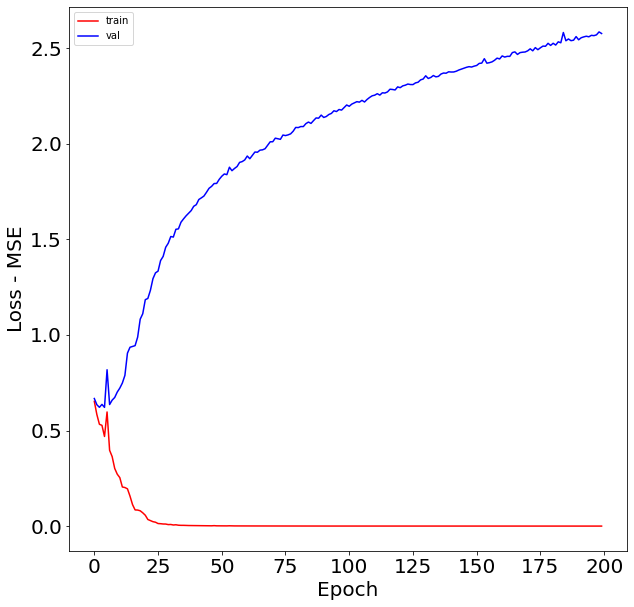

In [39]:
# loss function
plt.figure(figsize=(10,10))
plt.plot(learning_curve[:,1], 'r', label='train')
plt.plot(learning_curve[:,2], 'b' ,label='val')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss - MSE', fontsize=20)
plt.legend()
plt.tick_params(labelsize=20)

In [40]:
# info about the model
print('Model arch:\n', model)
# Model accuracy
acc = np.sum(y_pred.argmax(1) == y_test) / len(y_test)
print(f'Accuracy = {acc:.2}%')

Model arch:
 Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=400, out_features=120, bias=True)
  (10): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=84, out_features=2, bias=True)
)
Accuracy = 0.66%


In [41]:
# Image Classification - Interpretability
model.eval()

# grab one test image
ind = 0
dataiter = iter(test_dl)
images, labels = dataiter.next()
img_input = images[ind].unsqueeze(0)
img_input.requires_grad = True

Approximation delta:  tensor([0.2110, 0.1687, 0.2796, 0.0381, 0.4293], device='cuda:0',
       dtype=torch.float64)


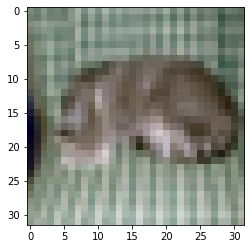

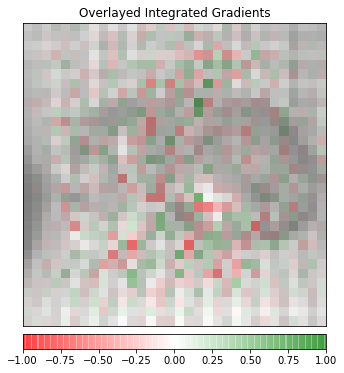

In [42]:
# get pixel attribution
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig, delta = nt.attribute(img_input, target=labels[ind],  baselines=img_input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

# plot pixel attribution
original_image = np.transpose(images[ind].cpu().detach().numpy().astype(int), (1, 2, 0))
plt.imshow(original_image)

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")